<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [477]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

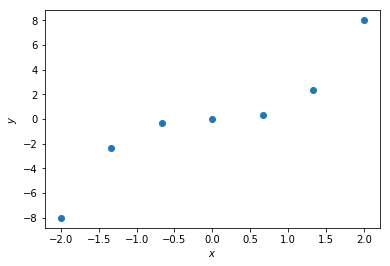

In [478]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

In [479]:
np.mean(y).round(2)

-0.0

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

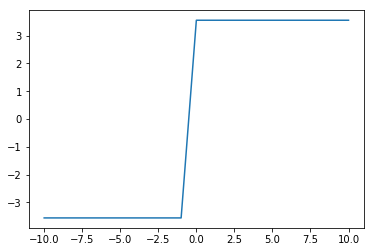

In [617]:
# Создаем массив
plt_data = np.zeros((20,2))
# Заполняем < 0
plt_data[0:10,0] = np.linspace(-10, 0, 10, endpoint=False)
plt_data[0:10,1] = np.mean(y[X<0])
# Заполняем > 0
plt_data[10:,0] = np.linspace(0, 10, 10)
plt_data[10:,1] = np.mean(y[X>0])
# Показываем график
plt.plot(plt_data[:,0], plt_data[:,1])

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [481]:
X_var = np.var(X)
X_size = X.size

def regression_var_criterion(t):
    X_l = X[X < t]
    X_r = X[X >= t]
    return X_var - X_l.size/X_size * np.var(X_l) - X_r.size/X_size * np.var(X_r)

Да, оптимально


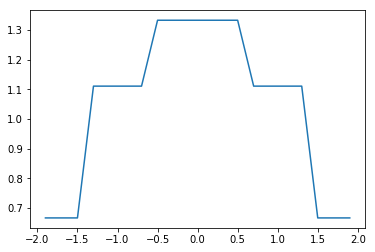

In [482]:
plt_data = np.zeros((20, 2))
plt_data[:,0] = np.linspace(-1.9, 1.9, 20)

for i,t in np.ndenumerate(plt_data[:,0]):
    plt_data[i,1] = regression_var_criterion(t)

plt.plot(plt_data[:,0], plt_data[:,1])
print('Да, оптимально')

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

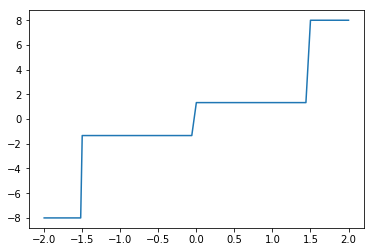

In [618]:
# Создаем массив
plt_data = np.zeros((100,2))
# Заполняем -1.5 < x
plt_data[0:25,0] = np.linspace(-2, -1.5, 25, endpoint=False)
plt_data[0:25,1] = np.mean(y[X < -1.5])
# Заполняем -1.5 < x < 0
plt_data[25:50,0] = np.linspace(-1.5, 0, 25, endpoint=False)
plt_data[25:50,1] = np.mean(y[(-1.5 < X) & (X < 0)])
# Заполняем 0 < x < 1.5
plt_data[50:75,0] = np.linspace(0, 1.5, 25, endpoint=False)
plt_data[50:75,1] = np.mean(y[(0 < X) & (X < 1.5)])
# Заполняем 1.5 < x
plt_data[75:100,0] = np.linspace(1.5, 2, 25)
plt_data[75:100,1] = np.mean(y[1.5 < X])
# Показываем график
plt.plot(plt_data[:,0], plt_data[:,1])

In [484]:
print('7 отрезков')

7 отрезков


**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [485]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [486]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [487]:
df['age_years'] = (df['age']/365.25).round().astype(int)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
id,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48


In [488]:
df3 = pd.get_dummies(data=df, columns=['cholesterol', 'gluc'])
df3.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,52,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,48,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [489]:
df3_train = df3.drop('cardio', axis=1)

X_train, X_valid, \
y_train, y_valid = train_test_split(df3_train.values,
                                    df3['cardio'].values.astype(int),
                                    test_size=0.3,
                                    random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [490]:
clf_tree = DecisionTreeClassifier(max_depth=3, random_state=17, max_features=16)
clf_tree.fit(X_train, y_train)

export_graphviz(clf_tree, out_file='task3_clf_tree2.dot', filled=True, 
                feature_names=df3_train.columns)
!dot -Tpng task3_clf_tree2.dot -o task3_clf_tree2.png
!rm task3_clf_tree2.dot

<img src="task3_clf_tree2.png">

In [491]:
print('Используются признаки: ap_hi, age, cholesterol_3')

Используются признаки: ap_hi, age, cholesterol_3


**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [492]:
y_predict = clf_tree.predict(X_valid)
accuracy_score(y_valid, y_predict)

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [493]:
tree_params = {'max_depth': list(range(2, 11))}
tree_grid = GridSearchCV(clf_tree, tree_params, cv=5, n_jobs=-1, verbose=True, return_train_score=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=16, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [494]:
tree_grid.best_params_

{'max_depth': 6}

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [495]:
df4 = pd.DataFrame(tree_grid.cv_results_)
df4.drop(['params'], axis=1)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.064905,0.002445,0.715510,0.715510,2,9,0.711560,0.716498,0.713265,0.716071,0.717551,0.715000,0.713571,0.715995,0.721604,0.713987,0.016214,0.000441,0.003625,0.000906
1,0.066210,0.002004,0.727714,0.727714,3,7,0.722069,0.729126,0.725612,0.728240,0.732653,0.726480,0.723980,0.728648,0.734259,0.726078,0.005746,0.000305,0.004847,0.001212
2,0.072157,0.001819,0.730490,0.730719,4,3,0.725436,0.731957,0.727653,0.731378,0.734184,0.729770,0.727755,0.731454,0.737422,0.729038,0.006641,0.000085,0.004534,0.001117
3,0.080918,0.002344,0.730959,0.733510,5,2,0.724926,0.734764,0.727143,0.733418,0.736224,0.733010,0.728367,0.734388,0.738137,0.731971,0.004667,0.000496,0.005233,0.000997
4,0.096574,0.002135,0.731959,0.735291,6,1,0.726048,0.737621,0.727755,0.735051,0.737449,0.734643,0.730204,0.735816,0.738341,0.733323,0.007033,0.000439,0.005031,0.001418
5,0.107278,0.002137,0.730388,0.739893,7,4,0.726150,0.742238,0.727653,0.740867,0.734082,0.738801,0.728878,0.739949,0.735177,0.737609,0.005067,0.000363,0.003586,0.001604
6,0.113266,0.002312,0.729490,0.744949,8,5,0.724416,0.747111,0.726939,0.744898,0.732041,0.743878,0.728571,0.746582,0.735483,0.742277,0.011990,0.000476,0.003886,0.001768
7,0.124182,0.001982,0.727980,0.750821,9,6,0.722069,0.753055,0.723469,0.750791,0.733265,0.749974,0.727857,0.751684,0.733238,0.748603,0.024364,0.000109,0.004709,0.001508
8,0.110032,0.001993,0.726163,0.758077,10,8,0.719314,0.760810,0.722347,0.757985,0.729286,0.755995,0.726939,0.757806,0.732932,0.757787,0.010605,0.000060,0.004851,0.001547


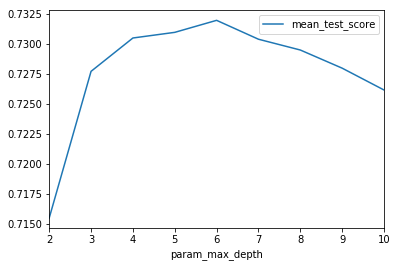

In [496]:
df4.plot(x='param_max_depth', y='mean_test_score')

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [497]:
df4 = df4.query('param_max_depth==3 or param_max_depth==6')[['param_max_depth', 'mean_test_score']]
acc1 = df4[df4['param_max_depth']==3]['mean_test_score'].iloc[0]
acc2 = df4[df4['param_max_depth']==6]['mean_test_score'].iloc[0]
print('acc1 =', acc1, 'acc2 =', acc2)
print('Прирост accuracy (%): ', (acc2-acc1)/acc1*100)
print('Ответ: да, нет')

acc1 = 0.727714285714 acc2 = 0.731959183673
Прирост accuracy (%):  0.583319311234
Ответ: да, нет


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [580]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,age_group
id,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,2
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,3
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,2
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,1


In [581]:
df['age_group'] = pd.cut(df['age_years'], [0,45,50,55,60,65,100],
                         right=False, retbins=False, labels=[-1,1,2,3,4,-2])

df['ap_hi_group'] = pd.cut(df['ap_hi'], [0,120,140,160,180,1000],
                         right=False, retbins=False, labels=[-1,1,2,3,-2])

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,age_group,ap_hi_group
id,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,2,-1
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,3,2
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,2,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,1,2
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,1,-1


In [601]:
df5 = pd.get_dummies(df, columns=['age_group', 'ap_hi_group', 'cholesterol'])
df5 = df5.drop(['age_group_-1', 'age_group_-2', 'ap_hi_group_-1', 'ap_hi_group_-2'], axis=1)
df5['gender'] = df5['gender']-1;
df5 = df5[['cardio',
           'gender', 'smoke', 
           'cholesterol_1', 'cholesterol_2', 'cholesterol_3',
           'age_group_1', 'age_group_2', 'age_group_3', 'age_group_4',
           'ap_hi_group_1', 'ap_hi_group_2', 'ap_hi_group_3']]
df5.head()

,cardio,gender,smoke,cholesterol_1,cholesterol_2,cholesterol_3,age_group_1,age_group_2,age_group_3,age_group_4,ap_hi_group_1,ap_hi_group_2,ap_hi_group_3
id,,,,,,,,,,,,,
0,0,1,0,1,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,1,0,0,1,0,0,1,0
2,1,0,0,0,0,1,0,1,0,0,1,0,0
3,1,1,0,1,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,1,0,0,0,0,0,0


In [616]:
df5_train = df5.drop('cardio', axis=1)
df5_valid = df5[['cardio']]

clf_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
clf_tree.fit(df5_train.values, df5_valid.values)

export_graphviz(clf_tree, out_file='task5_clf_tree.dot', 
                filled=True, feature_names=df5_train.columns)
!dot -Tpng task5_clf_tree.dot -o task5_clf_tree.png
!rm task5_clf_tree.dot

print('Самый важный признак 140 <= ap_hi < 160')

Самый важный признак 140 <= ap_hi < 160


<img src="task5_clf_tree.png">